# Validation of distances between related Embeddings

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import util.util_validation as ut_val

### Parameters

In [2]:
cuda_device = 0
tsenecuda_venv = "/home/tgottwald/tsnecuda_venv/"

# untrained
# root_model = "./save/SupCE/untrained/SupCE_untrained_resnet18_lr_0.0_decay_0.0001_bsz_26_trial_0_noTraining/models/last.pth"

# animals10
# SupCE
# root_model = "./save/SupCE/animals10/SupCE_animals10_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_baseline_cosine/models/last.pth"

# root_model = "./save/SupCE/animals10_diff_4000/SupCE_animals10_diff_4000_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_4000_cosine/models/last.pth"
# root_model = "./save/SupCE/animals10_diff_8000/SupCE_animals10_diff_8000_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_8000_cosine/models/last.pth"

# root_model = "./save/SupCE/animals10_diff_-1_small/SupCE_animals10_diff_-1_small_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_origSmall_cosine/models/last.pth"
# root_model = "./save/SupCE/animals10_diff_4000_small/SupCE_animals10_diff_4000_small_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_4000Small_cosine/models/last.pth"

# root_model = "./save/SupCE/animals10_diff_-1+4000/SupCE_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_diffAug_cosine/models/last.pth"
# root_model = "./save/SupCE/animals10_diff_-1+4000/SupCE_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_diffAugAllAug_cosine/models/last.pth"

# SupCon
# root_model = "./save/SupCon/animals10_diff_-1/SupCon_animals10_diff_-1_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_try3_cosine/models/last.pth"

# root_model = "./save/SupCon/animals10_diff_-1+4000/SupCon_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_noAug_cosine/models/last.pth"
# root_model = "./save/SupCon/animals10_diff_-1+4000/SupCon_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_colorAugSameShapeAug_cosine/models/last.pth"

# SupConHybrid
# root_model = "./save/SupCon/animals10_diff_-1+4000/SupConHybrid_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_noAug_cosine/models/last.pth"
# root_model = "./save/SupCon/animals10_diff_-1+4000/SupConHybrid_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_colorAug_cosine/models/last.pth"

# SupCon factor
root_model = "./save/SupCon/animals10_diff_-1+4000/SupCon_5.0_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_factor5cAugSameSAug_cosine/models/ckpt_epoch_150.pth"

# city_scapes
# SupCE
# root_model = "./save/SupCE/city_classification_original/SupCE_city_classification_original_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_cityBaseline_cosine/models/last.pth"
# root_model = "./save/SupCE/city_classification_diff/SupCE_city_classification_diff_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_cityDiff_cosine/models/last.pth"

dataset_1 = "animals10_diff_-1"
dataset_2 = "animals10_diff_4000"

aug_dict = {'aug': [], 'resizedCrop': [0.5, 1.0, 3/4, 4/3], 'horizontalFlip': 0.5, 'colorJitter': [0.8, 0.4, 0.4, 0.4, 0.4], 'grayscale': 0.2}


root_train_1, root_test_1 = ut_val.get_root_dataset(dataset_1)
root_train_2, root_test_2 = ut_val.get_root_dataset(dataset_2)

path_save, path_run_md, path_val_md_1, path_val_md_2, path_comb_md, path_comb, path_embeddings_1, path_embeddings_2, epoch = ut_val.get_paths_to_embeddings_and_run_md(root_model, dataset_1, dataset_2)

params = ut_val.read_parameters_from_run_md(path_run_md)

### Model and DataLoaders

In [3]:
if len(aug_dict['aug']) > 0:
    train_loader, val_loader = ut_val.set_dataloader(dataset_1, params, root_train_1, root_test_1, root_train_2, root_test_2, aug_dict)

    model = ut_val.set_model(root_model, params, len(val_loader.dataset.classes), cuda_device)

### Embeddings

In [5]:
with open(os.path.join(path_embeddings_1, "embedding_test"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_test_1 = entry['data']
    class_labels_test = entry['labels']

with open(os.path.join(path_embeddings_2, "embedding_test"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_test_2 = entry['data']

if len(aug_dict['aug']) == 0:
    with open(os.path.join(path_embeddings_1, "embedding_train"), 'rb') as f:
        entry = pickle.load(f, encoding='latin1')
        embedding_train_1 = entry['data']
        class_labels_train = entry['labels']

    with open(os.path.join(path_embeddings_2, "embedding_train"), 'rb') as f:
        entry = pickle.load(f, encoding='latin1')
        embedding_train_2 = entry['data']
else:
    embedding_aug_1, embedding_aug_2, class_labels_aug = ut_val.compute_diff_embeddings(model, val_loader, params, cuda_device)

### Investigate Distances

In [6]:
mean_dist, mean_dist_class, mean_dist_all = ut_val.compute_mean_distance(embedding_test_1, embedding_test_2, class_labels_test)
print("Mean Distances:")
print(f"Related Images: {mean_dist:.4f}")
print(f"Mean for same Class: {mean_dist_class:.4f}")
print(f"All versus all: {mean_dist_all:.4f}")

df_dist = pd.DataFrame.from_dict({"Related_Images": [mean_dist], "Same_Class": [mean_dist_class], "All_versus_all": [mean_dist_all]})
df_dist.to_csv(os.path.join(path_embeddings_1, f"{dataset_1}_dist_to_{dataset_2}.csv"), index=False)

100%|██████████| 5236/5236 [00:40<00:00, 128.51it/s]


Mean Distances:
Related Images: 0.0231
Mean for same Class: 0.3344
All versus all: 0.4445


In [17]:
import torch
from tqdm import tqdm

#### SupConFactor_factor5cAugSameSAug

<BarContainer object of 100 artists>

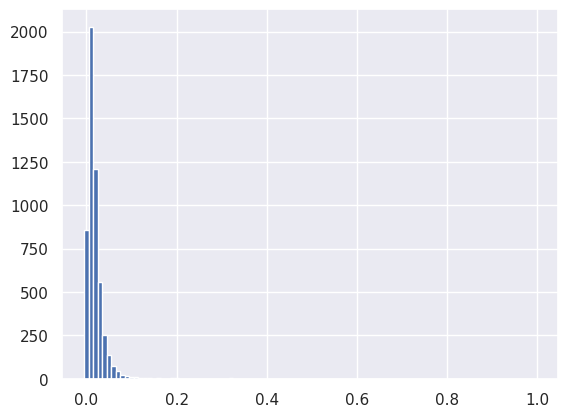

In [18]:
# related distances
distances_embeddings = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_test_1), torch.tensor(embedding_test_2))

n_bins = 100

bins_related = np.zeros(n_bins, dtype=int)
for d in distances_embeddings:
    bins_related[int(d*n_bins)] += 1

plt.bar(np.arange(start=0, stop=1, step=1/n_bins), bins_related, width=1/n_bins)

100%|██████████| 10/10 [00:34<00:00,  3.48s/it]


<BarContainer object of 100 artists>

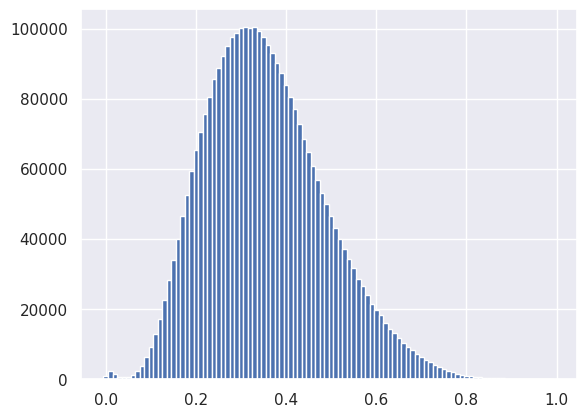

In [19]:
# in class distances
n_bins = 100

bins_class = np.zeros(n_bins, dtype=int)
for l in tqdm(range(len(set(class_labels_test)))):
    class_indices = np.where(class_labels_test == l)[0]

    embedding_class_1 = embedding_test_1[class_indices]
    embedding_class_2 = embedding_test_2[class_indices]

    for s in range(len(class_indices)):
        distances_embeddings_class = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_class_1), torch.tensor(embedding_class_2).roll(s, dims=0))
        for d in distances_embeddings_class:
            bins_class[int(d*n_bins)] += 1

plt.bar(np.arange(start=0, stop=1, step=1/n_bins), bins_class, width=1/n_bins)

100%|██████████| 5236/5236 [04:41<00:00, 18.59it/s]


<BarContainer object of 100 artists>

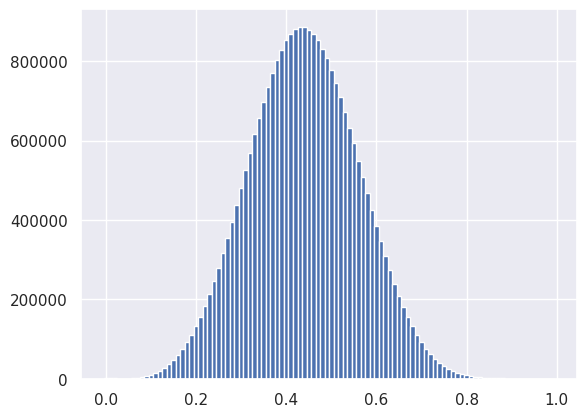

In [20]:
# all versus all distances
n_bins = 100

bins_all = np.zeros(n_bins, dtype=int)
for s in tqdm(range(len(class_labels_test))):
    distances_embeddings_roll = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_test_1), torch.tensor(embedding_test_2).roll(s, dims=0))
    for d in distances_embeddings_roll:
        bins_all[int(d*n_bins)] += 1

plt.bar(np.arange(start=0, stop=1, step=1/n_bins), bins_all, width=1/n_bins)

#### CE_diffAugAllAug

<BarContainer object of 100 artists>

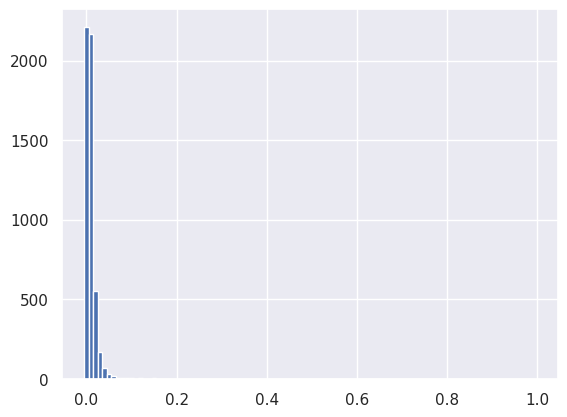

In [80]:
# related distances
distances_embeddings = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_test_1), torch.tensor(embedding_test_2))

n_bins = 100

bins_related = np.zeros(n_bins, dtype=int)
for d in distances_embeddings:
    bins_related[int(d*n_bins)] += 1

plt.bar(np.arange(start=0, stop=1, step=1/n_bins), bins_related, width=1/n_bins)

#### CE_diffAug

<BarContainer object of 100 artists>

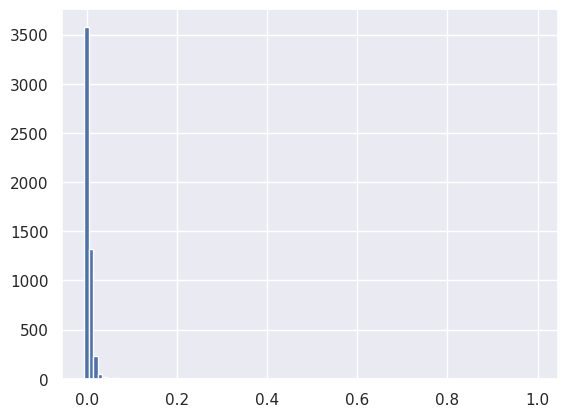

In [73]:
# related distances
distances_embeddings = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_test_1), torch.tensor(embedding_test_2))

n_bins = 100

bins_related = np.zeros(n_bins, dtype=int)
for d in distances_embeddings:
    bins_related[int(d*n_bins)] += 1

plt.bar(np.arange(start=0, stop=1, step=1/n_bins), bins_related, width=1/n_bins)

100%|██████████| 10/10 [00:50<00:00,  5.03s/it]


<BarContainer object of 100 artists>

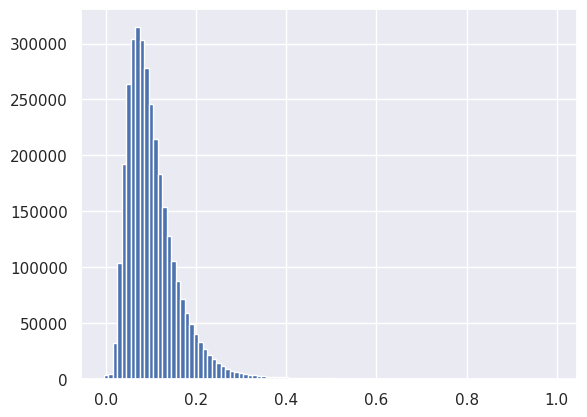

In [74]:
# in class distances
n_bins = 100

bins_class = np.zeros(n_bins, dtype=int)
for l in tqdm(range(len(set(class_labels_test)))):
    class_indices = np.where(class_labels_test == l)[0]

    embedding_class_1 = embedding_test_1[class_indices]
    embedding_class_2 = embedding_test_2[class_indices]

    for s in range(len(class_indices)):
        distances_embeddings_class = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_class_1), torch.tensor(embedding_class_2).roll(s, dims=0))
        for d in distances_embeddings_class:
            bins_class[int(d*n_bins)] += 1

plt.bar(np.arange(start=0, stop=1, step=1/n_bins), bins_class, width=1/n_bins)

#### SupCon_diff_noAug

<BarContainer object of 100 artists>

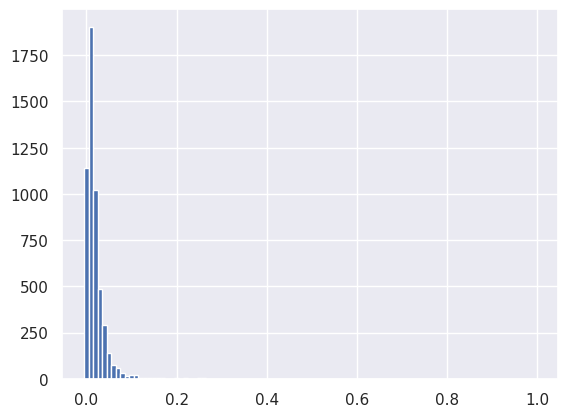

In [68]:
# related distances
distances_embeddings = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_test_1), torch.tensor(embedding_test_2))

n_bins = 100

bins_related = np.zeros(n_bins, dtype=int)
for d in distances_embeddings:
    bins_related[int(d*n_bins)] += 1

plt.bar(np.arange(start=0, stop=1, step=1/n_bins), bins_related, width=1/n_bins)

100%|██████████| 10/10 [00:45<00:00,  4.52s/it]


<BarContainer object of 100 artists>

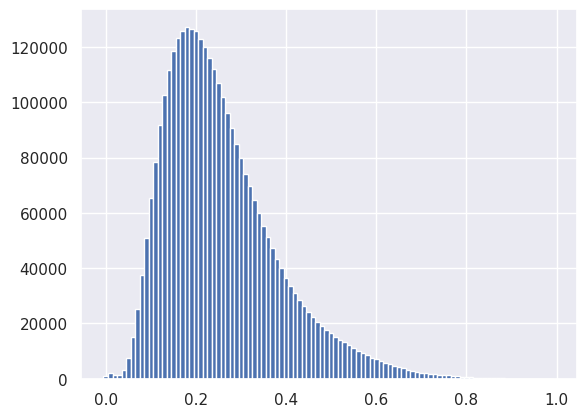

In [69]:
# in class distances
n_bins = 100

bins_class = np.zeros(n_bins, dtype=int)
for l in tqdm(range(len(set(class_labels_test)))):
    class_indices = np.where(class_labels_test == l)[0]

    embedding_class_1 = embedding_test_1[class_indices]
    embedding_class_2 = embedding_test_2[class_indices]

    for s in range(len(class_indices)):
        distances_embeddings_class = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_class_1), torch.tensor(embedding_class_2).roll(s, dims=0))
        for d in distances_embeddings_class:
            bins_class[int(d*n_bins)] += 1

plt.bar(np.arange(start=0, stop=1, step=1/n_bins), bins_class, width=1/n_bins)

#### CE_baseline

<BarContainer object of 100 artists>

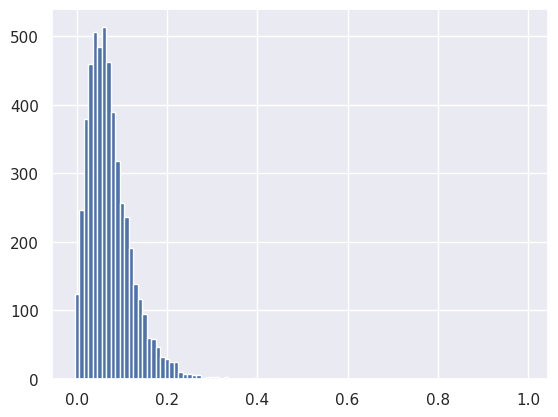

In [60]:
# related distances
distances_embeddings = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_test_1), torch.tensor(embedding_test_2))

n_bins = 100

bins_related = np.zeros(n_bins, dtype=int)
for d in distances_embeddings:
    bins_related[int(d*n_bins)] += 1

plt.bar(np.arange(start=0, stop=1, step=1/n_bins), bins_related, width=1/n_bins)

100%|██████████| 10/10 [00:44<00:00,  4.44s/it]


<BarContainer object of 100 artists>

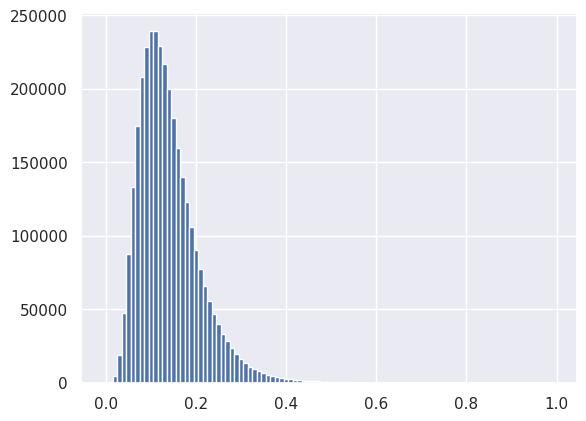

In [63]:
# in class distances
n_bins = 100

bins_class = np.zeros(n_bins, dtype=int)
for l in tqdm(range(len(set(class_labels_test)))):
    class_indices = np.where(class_labels_test == l)[0]

    embedding_class_1 = embedding_test_1[class_indices]
    embedding_class_2 = embedding_test_2[class_indices]

    for s in range(len(class_indices)):
        distances_embeddings_class = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_class_1), torch.tensor(embedding_class_2).roll(s, dims=0))
        for d in distances_embeddings_class:
            bins_class[int(d*n_bins)] += 1

plt.bar(np.arange(start=0, stop=1, step=1/n_bins), bins_class, width=1/n_bins)

100%|██████████| 5236/5236 [05:01<00:00, 17.36it/s]


<BarContainer object of 100 artists>

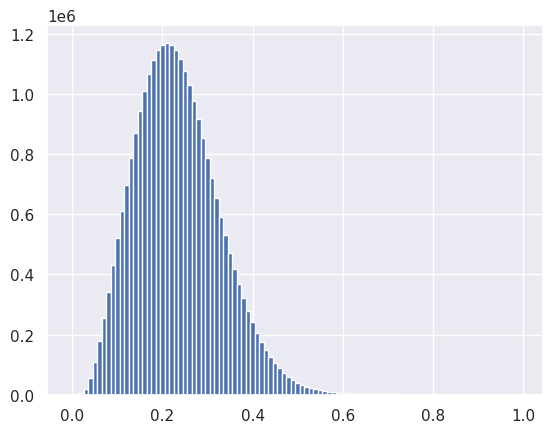

In [64]:
# all versus all distances
n_bins = 100

bins_all = np.zeros(n_bins, dtype=int)
for s in tqdm(range(len(class_labels_test))):
    distances_embeddings_roll = 1-torch.nn.functional.cosine_similarity(torch.tensor(embedding_test_1), torch.tensor(embedding_test_2).roll(s, dims=0))
    for d in distances_embeddings_roll:
        bins_all[int(d*n_bins)] += 1

plt.bar(np.arange(start=0, stop=1, step=1/n_bins), bins_all, width=1/n_bins)

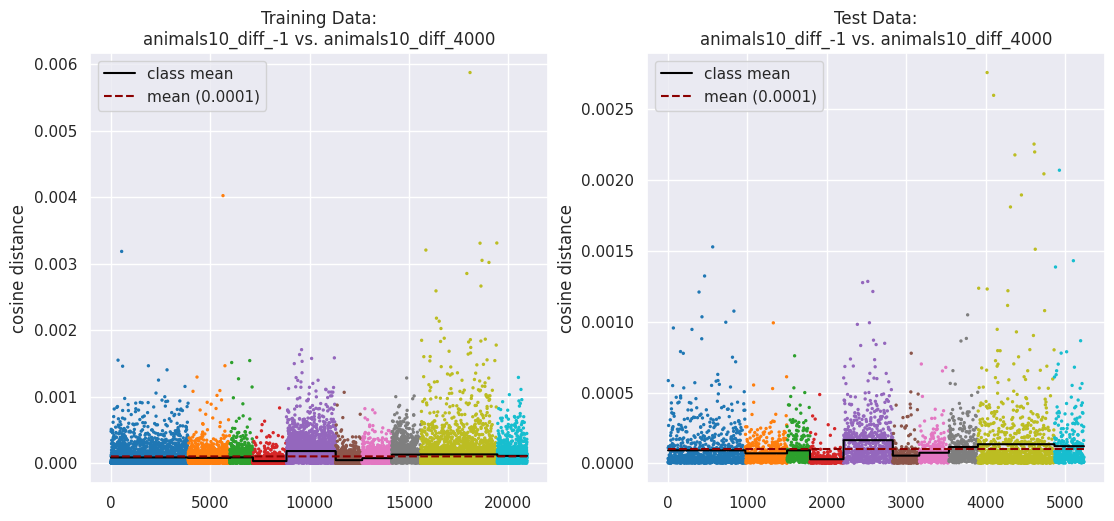

In [4]:
if len(aug_dict['aug']) == 0:
    ut_val.plot_distances(dataset_1, dataset_2, embedding_train_1, embedding_train_2, class_labels_train, embedding_test_1, embedding_test_2, class_labels_test)
else:
    ut_val.plot_aug_distances(dataset_1, dataset_2, embedding_test_1, embedding_test_2, embedding_aug_1, embedding_aug_2, class_labels_test, aug_dict['aug'])

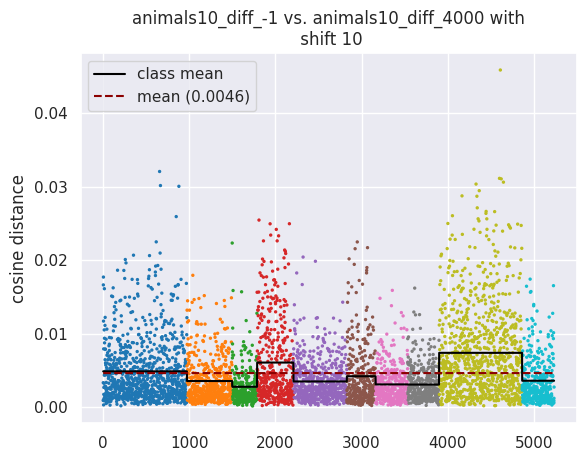

In [5]:
ut_val.plot_roll_distances(shifts=10, dataset_1=dataset_1, dataset_2=dataset_2, embedding_1=embedding_test_1, embedding_2=embedding_test_2, class_labels=class_labels_test)

-------

### Experiment with estimation of used dimensions for shape

In [8]:
import torch

In [9]:
# calculate score of feature dimensions over all original diffused pairs
# based on https://github.com/CompVis/iin (iin/iin/iterators/base.py line: 181 "def dim_callback...")
za = embedding_test_1
zb = embedding_test_2

zall = np.concatenate([za, zb], 0)
mean = np.mean(zall, 0, keepdims=True)
var = np.sum(np.mean((zall-mean)*(zall-mean), 0))

zmean = 0.5 * (np.mean(za, 0, keepdims=True) + np.mean(zb, 0, keepdims=True))

score = np.sum(np.mean((za-zmean)*(zb-zmean), 0))/var
score

scores = np.array([score, 1.0])

m = np.max(scores)
e = np.exp(scores-m)
softmaxed = e / np.sum(e)

dim = za.shape[1]
dims = [int(s*dim) for s in softmaxed]
dims[-1] = dim - sum(dims[:-1])
dims

[251, 261]

In [10]:
# calculate correlation coefficients of feature dimensions over all original diffused pairs
A = torch.tensor(embedding_test_1)
B = torch.tensor(embedding_test_2)

A_dm = A - A.mean(dim=0)
B_dm = B - B.mean(dim=0)

correlation = (A_dm.T * B_dm.T).sum(dim=1) / ((A_dm.T * A_dm.T).sum(dim=1) * (B_dm.T * B_dm.T).sum(dim=1)).sqrt()
correlation = torch.nan_to_num(correlation, nan=0.0)

s_F = correlation.mean().item()

scores = np.array([s_F, 1.0])

m = np.max(scores)
e = np.exp(scores-m)
softmaxed = e / np.sum(e)

dim = A.shape[1]
dims = [int(s*dim) for s in softmaxed]
dims[-1] = dim - sum(dims[:-1])
dims

[250, 262]

-----------

### t-SNE of two Datasets

In [13]:
path_tsne_save = os.path.join(path_comb, f"{epoch}")

sample_size = 10

tsenecuda_venv_lib64 = os.path.join(tsenecuda_venv, "lib64")
tsenecuda_venv_interpreter = os.path.join(tsenecuda_venv, "bin/python")

In [22]:
!CUDA_VISIBLE_DEVICES={cuda_device} LD_LIBRARY_PATH={tsenecuda_venv_lib64} {tsenecuda_venv_interpreter} compute_tsne.py --path {path_embeddings_1} --path_second {path_embeddings_2} --path_save {path_tsne_save}

Data split train
load feature embedding
load second feature embedding
compute t-SNE embedding
writ t-SNE embedding
Data split test
load feature embedding
load second feature embedding
compute t-SNE embedding
writ t-SNE embedding


In [23]:
with open(os.path.join(path_tsne_save, "embedding_tSNE_train"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_tSNE_train = entry['data']
    labels_train = entry['labels']
N_train = len(labels_train)//2
num_classes = len(set(labels_train))
df_train = pd.DataFrame.from_dict({'x': embedding_tSNE_train[:,0], 'y': embedding_tSNE_train[:,1], 'label': labels_train,
                                   'dataset': N_train*[dataset_1]+N_train*[dataset_2], 'dataset_label': N_train*[0]+N_train*[1]})

with open(os.path.join(path_tsne_save, "embedding_tSNE_test"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_tSNE_test = entry['data']
    labels_test = entry['labels']
N_test = len(labels_test)//2
df_test = pd.DataFrame.from_dict({'x': embedding_tSNE_test[:,0], 'y': embedding_tSNE_test[:,1], 'label': labels_test,
                                   'dataset': N_test*[dataset_1]+N_test*[dataset_2], 'dataset_label': N_test*[0]+N_test*[1]})

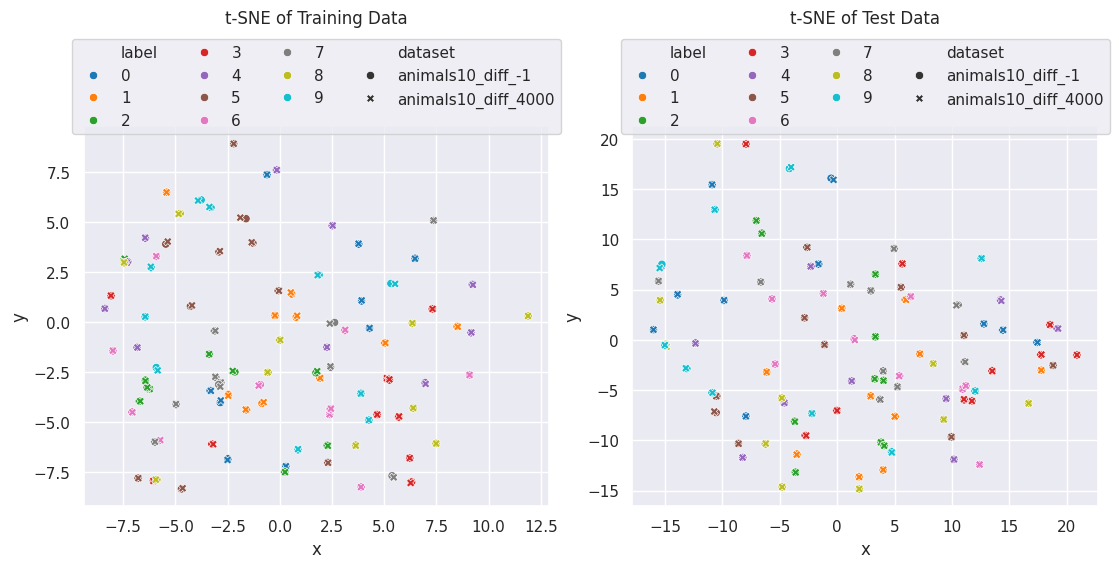

In [71]:
seaborn.set_theme(style="darkgrid")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,4.5))
fig.tight_layout(w_pad=2)

df_train_sample = df_train[df_train.dataset_label == 0].groupby('label').sample(sample_size)
indices_train = np.array([[idx, idx+N_train] for idx in df_train_sample.index]).reshape(-1)
seaborn.scatterplot(data=df_train.loc[indices_train], x='x', y='y', hue='label', style='dataset', palette='tab10', ax=axs[0])
axs[0].set_title("t-SNE of Training Data", y=1.25)
axs[0].legend(loc="upper center", ncols=4, bbox_to_anchor=(0.5,1.25))

df_test_sample = df_test[df_test.dataset_label == 0].groupby('label').sample(sample_size)
indices_test = np.array([[idx, idx+N_test] for idx in df_test_sample.index]).reshape(-1)
seaborn.scatterplot(data=df_test.loc[indices_test], x='x', y='y', hue='label', style='dataset', palette='tab10', ax=axs[1])
axs[1].set_title("t-SNE of Test Data", y=1.25)
axs[1].legend(loc="upper center", ncols=4, bbox_to_anchor=(0.5,1.25))